# Data Preparation

In [83]:
import numpy as np
import pandas as pd
import seaborn as sns
import os 

from matplotlib import pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

### LOAD DATASETS & PLANNING

In [84]:
raw_datasets_path = os.path.abspath(os.path.join('raw_datasets'))
cleaned_datasets_path = os.path.abspath(os.path.join('cleaned_datasets'))

In [85]:
# LOAD 2023 PROPERTY SALE DATA
def load_data(filename):
    return pd.read_csv(os.path.join(raw_datasets_path, filename))

df_sale_2023_raw = load_data('jabodetabek_house_price.csv')
df_sale_raw = load_data('rumah123_sale_properties.csv')
df_rent_raw = load_data('rumah123_rent_properties.csv')

### DATA CLEANING

**Column Cleanup and Reordering**

- Removed the `building_age` column, which was not reliable or informative for our modeling needs.
- Reordered columns in both sale and rent datasets to follow a consistent structure for readability and future preprocessing.
- In the rent dataset, renamed `price_in_rp` to `rent_price_per_year` to distinguish it from sale price and reflect its annual nature.


In [86]:
# Remove building_age feature
df_sale = df_sale_raw.drop(columns=['building_age'], errors='ignore')
df_rent = df_rent_raw.drop(columns=['building_age'], errors='ignore')

# re-order columns
df_sale = df_sale[['url', 'title', 'price_in_rp', 'district', 'city' , 'bedrooms', 'bathrooms', 'land_size_m2', 'building_size_m2','certificate', 'electricity_power', 'property_condition', 'floor_count', 'description']]

df_rent = df_rent[['url', 'title', 'price_in_rp', 'district', 'city' , 'bedrooms', 'bathrooms', 'land_size_m2', 'building_size_m2','certificate', 'electricity_power', 'property_condition', 'floor_count', 'description']]
df_rent.rename(columns={'price_in_rp': 'rent_price_per_year'}, inplace=True)

**Aligning Historical Data (Sale 2023)**

- Renamed key columns in the 2023 sale dataset to match the structure used in the 2025 dataset.
- Unused or irrelevant columns such as `maid_bedrooms`, `lat`, `ads_id`, etc., were omitted.
- Reordered columns to maintain a uniform schema across all datasets, simplifying downstream processing.


In [87]:
# rename + re-order sale_2023 data
df_sale_2023 = df_sale_2023_raw.rename(columns={
    'url': 'url', 
    'price_in_rp': 'price_in_rp', 
    'title': 'title', 
    # 'address': 'location', 
    'district': 'district', 
    'city': 'city', 
    # 'lat',
    # 'long', 
    'facilities': 'description', 
    # 'property_type', 
    # 'ads_id', 
    'bedrooms': 'bedrooms',
    'bathrooms': 'bathrooms', 
    'land_size_m2': 'land_size_m2', 
    'building_size_m2': 'building_size_m2', 
    # 'carports'
    'certificate': 'certificate', 
    'electricity': 'electricity_power', 
    # 'maid_bedrooms', 
    # 'maid_bathrooms',
    'floors': 'floor_count', 
    # 'building_age', 
    # 'year_built', 
    'property_condition': 'property_condition',
    # 'building_orientation', 
    # 'garages', 
    # 'furnishing'    
}).copy()

df_sale_2023 = df_sale_2023[['url', 'title', 'price_in_rp', 'district', 'city' , 'bedrooms', 'bathrooms', 'land_size_m2', 'building_size_m2', 'certificate', 'electricity_power', 'property_condition', 'floor_count', 'description']]

**Check Data Types**

Displayed the data types of all columns in both the sale and rent datasets.  
This step is useful for identifying non-numeric columns that need to be converted before modeling.

In [88]:
# check the data types of each column prior to conversion
print(df_sale.dtypes)
print(df_rent.dtypes)

url                    object
title                  object
price_in_rp            object
district               object
city                   object
bedrooms              float64
bathrooms             float64
land_size_m2           object
building_size_m2       object
certificate            object
electricity_power      object
property_condition     object
floor_count           float64
description            object
dtype: object
url                     object
title                   object
rent_price_per_year     object
district                object
city                    object
bedrooms               float64
bathrooms              float64
land_size_m2            object
building_size_m2        object
certificate             object
electricity_power       object
property_condition      object
floor_count            float64
description             object
dtype: object


**Numeric Data Type Conversion**

- Converted string-based `price_in_rp` and `rent_price_per_year` fields to numeric (float), including parsing currency symbols, thousand/million/billion markers, and time-based rent normalization (monthly/yearly).
- Cleaned and converted `land_size_m2` and `building_size_m2` from text like `"120 m²"` to float.
- Standardized and converted `electricity_power` from labels like `"2.200 Watt"` or `"Lainnya"` to numeric watts.
- Replaced certain certificate types (e.g. `PPJB`, `Hak Sewa`) with `"Lainnya"` to consolidate categories and make it the same as the historical data (2023).


In [89]:
# --- Price Conversion ---
def parse_price_string(value, is_rent=False):
    if not isinstance(value, str):
        return value

    value = value.replace('Rp', '').replace(',', '.').strip()

    # Period multiplier (for rent)
    period = 1
    if is_rent:
        if '/bulan' in value or 'per bulan' in value:
            value = value.replace('/bulan', '').replace('per bulan', '').strip()
            period = 12
        elif '/tahun' in value or 'per tahun' in value:
            value = value.replace('/tahun', '').replace('per tahun', '').strip()
            period = 1
        elif '/hari' in value or 'per hari' in value:
            value = value.replace('/hari', '').replace('per hari', '').strip()
            period = 365

    # Unit conversion
    multiplier = 1
    if 'Triliun' in value:
        value = value.replace('Triliun', '').strip()
        multiplier = 1_000_000_000_000
    elif 'Miliar' in value:
        value = value.replace('Miliar', '').strip()
        multiplier = 1_000_000_000
    elif 'Juta' in value:
        value = value.replace('Juta', '').strip()
        multiplier = 1_000_000
    elif 'Ribu' in value:
        value = value.replace('Ribu', '').strip()
        multiplier = 1_000

    try:
        return float(value) * multiplier * period
    except ValueError:
        return np.nan

df_sale['price_in_rp'] = df_sale['price_in_rp'].apply(parse_price_string)
df_rent['rent_price_per_year'] = df_rent['rent_price_per_year'].apply(lambda x: parse_price_string(x, is_rent=True))

# --- Area Conversion ---
for col in ['land_size_m2', 'building_size_m2']:
    for df in [df_sale, df_rent]:
        if df[col].dtype == 'object':
            df[col] = df[col].str.replace('m²', '', regex=True).str.replace(',', '.', regex=True).astype(float)

# --- Electricity Conversion ---
for df in [df_sale, df_rent]:
    if df['electricity_power'].dtype == 'object':
        df['electricity_power'] = (
            df['electricity_power']
            .str.replace('Lainnya', '0', regex=True)
            .str.replace('Watt', '', regex=True)
            .str.replace(',', '.', regex=True)
            .astype(float)
        )

# --- Certificate Normalization ---
df_sale['certificate'] = df_sale['certificate'].replace(['PPJB', 'Hak Sewa'], 'Lainnya')
df_rent['certificate'] = df_rent['certificate'].replace(['PPJB', 'Hak Sewa'], 'Lainnya')


**Numeric and Categorical Cleaning (2023 House Sales Data)**

- Converted `electricity_power` from string values like `"2200mah"` into float, assuming `1 mAh ≈ 1 Watt` for compatibility with 2025 data.
- Mapped raw `property_condition` values into grouped standard categories (e.g., `"bagus sekali"` → `"Baru"`).
- Standardized `certificate` values from free-text entries into official labels such as `"SHM"` and `"HGB"`.
- Trimmed whitespaces in `district` and `city` columns to ensure consistency in grouping and filtering.


In [90]:
# --- Electricity Power (convert 'mah' to 'watt') ---
# Assumption: 1 mAh ≈ 1 Watt (range is similar to watt values in 2025 data)
if df_sale_2023['electricity_power'].dtype == 'object':
    df_sale_2023['electricity_power'] = (
        df_sale_2023['electricity_power']
        .str.replace('lainnya', '0', regex=True)
        .str.replace('mah', '', regex=True)
        .str.replace(',', '.', regex=True)
        .astype(float)
    )

# --- Property Condition Mapping ---
property_condition_mapping = {
    'baru': 'Baru',
    'bagus sekali': 'Baru',
    'bagus': 'Bagus',
    'sudah renovasi': 'Sudah Renovasi',
    'semi furnished': 0,
    'butuh renovasi': 'Butuh Renovasi',
    'unfurnished': 0
}
if df_sale_2023['property_condition'].dtype == 'object':
    df_sale_2023['property_condition'] = df_sale_2023['property_condition'].map(property_condition_mapping)

# --- Certificate Cleaning ---
df_sale_2023['certificate'] = df_sale_2023['certificate'].replace(
    [
        'shm - sertifikat hak milik',
        'hgb - hak guna bangunan',
        'lainnya (ppjb,girik,adat,dll)',
        'hp - hak pakai'
    ],
    ['SHM', 'HGB', 'Lainnya', 'Hak Pakai']
)

# --- Whitespace Cleanup for Categorical Columns ---
df_sale_2023['district'] = df_sale_2023['district'].str.strip()
df_sale_2023['city'] = df_sale_2023['city'].str.strip()

**Filter Jabodetabek Cities Only**

Filtered the dataset to include only properties located in Jabodetabek:
- Jakarta (all municipalities)
- Bogor
- Depok
- Tangerang
- Bekasi

This geographic filter ensures the portfolio optimization focuses on the target metropolitan area defined in the research scope.


In [91]:
# Keep only properties located in Jabodetabek cities
jabodetabek_cities = [
    'Bekasi', 'Bogor', 'Depok',
    'Jakarta Barat', 'Jakarta Selatan', 'Jakarta Utara', 'Jakarta Timur', 'Jakarta Pusat',
    'Tangerang'
]
df_sale.query("city in @jabodetabek_cities", inplace=True)


**Duplicate and Null Value Handling**

- Verified that no duplicate entries exist in `df_sale`, `df_rent`, or `df_sale_2023`.
- Applied null handling based on feature importance and dataset context:

**For `df_sale`:**
- Dropped all rows with missing values due to its limited and cleaner size.

**For `df_rent`:**
- Dropped rows with missing critical features: `rent_price_per_year`, `land_size_m2`, `building_size_m2`, `electricity_power`.
- Imputed missing values in:
  - `bedrooms`, `bathrooms`, `floor_count` with **median values**
  - `property_condition` with a constant (`0` as placeholder)

**For `df_sale_2023`:**
- Dropped rows missing essential size indicators: `land_size_m2`, `building_size_m2`.
- Imputed:
  - `bedrooms`, `bathrooms` with **median**
  - `certificate`, `property_condition`, `district` with constant fallback (`0` or "unknown")

These decisions balance between data integrity and dataset completeness for machine learning model readiness.


In [92]:
# DUPLICATE HANDLING
# No duplicate entries found in: df_sale, df_rent, df_sale_2023

# NULL VALUES HANDLING

# df_sale: drop rows with any null values
df_sale.dropna(subset=df_sale.columns[df_sale.isnull().any()].tolist(), inplace=True)

# df_rent:
# Drop if key structural features are missing
df_rent.dropna(subset=['rent_price_per_year', 'land_size_m2', 'building_size_m2', 'electricity_power'], inplace=True)
# Impute common missing values using median (for numerical) or constant (for categorical)
df_rent['bedrooms'] = df_rent['bedrooms'].fillna(df_rent['bedrooms'].median())
df_rent['bathrooms'] = df_rent['bathrooms'].fillna(df_rent['bathrooms'].median())
df_rent['floor_count'] = df_rent['floor_count'].fillna(df_rent['floor_count'].median())
df_rent['property_condition'] = df_rent['property_condition'].fillna(0)

# df_sale_2023:
df_sale_2023.dropna(subset=['land_size_m2', 'building_size_m2'], inplace=True)
df_sale_2023['bedrooms'] = df_sale_2023['bedrooms'].fillna(df_sale_2023['bedrooms'].median())
df_sale_2023['bathrooms'] = df_sale_2023['bathrooms'].fillna(df_sale_2023['bathrooms'].median())
df_sale_2023['certificate'] = df_sale_2023['certificate'].fillna(0)
df_sale_2023['property_condition'] = df_sale_2023['property_condition'].fillna(0)
df_sale_2023['district'] = df_sale_2023['district'].fillna(0)

**Remove Price Outliers (IQR Method)**

- Applied the **Interquartile Range (IQR)** technique to remove extreme outliers in the datasets.
- Target columns for outlier filtering:
  - `price_in_rp` in `df_sale` and `df_sale_2023`
  - `rent_price_per_year` in `df_rent`
- This ensures the models are not skewed by abnormally high or low property values that could distort learning patterns or investment decisions.


In [93]:
# REMOVE PRICE OUTLIERS using IQR method
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# remove outliers for price_in_rp
df_sale = remove_outliers_iqr(df_sale, 'price_in_rp')
df_rent = remove_outliers_iqr(df_rent, 'rent_price_per_year')
df_sale_2023 = remove_outliers_iqr(df_sale_2023, 'price_in_rp')

df_sale = remove_outliers_iqr(df_sale, 'land_size_m2')

**Save Cleaned Data**

In [94]:
# SAVE CLEANED DATA
os.makedirs(cleaned_datasets_path, exist_ok=True)

def save_cleaned_data(df, filename):
    df.to_csv(os.path.join(cleaned_datasets_path, filename), index=False)

save_cleaned_data(df_sale, 'rumah123_2025_sale_properties_cleaned.csv')
save_cleaned_data(df_rent, 'rumah123_2025_rent_properties_cleaned.csv')
save_cleaned_data(df_sale_2023, 'rumah123_2023_sale_properties_cleaned.csv')

### Exploratory Data Analysis

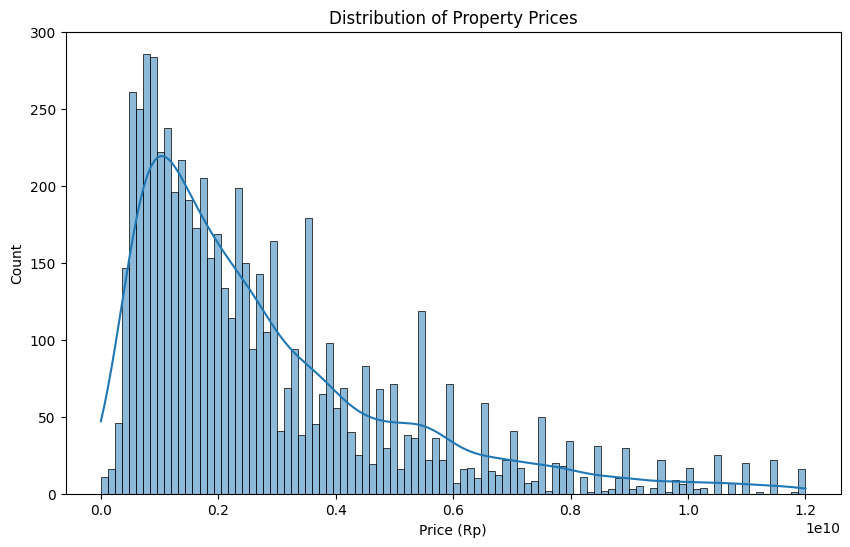

In [95]:
import seaborn as sns

# ── Distribution of Prices ──
plt.figure(figsize=(10,6))
sns.histplot(df_sale['price_in_rp'], bins=100, kde=True)
plt.title("Distribution of Property Prices")
plt.xlabel("Price (Rp)")
plt.show()

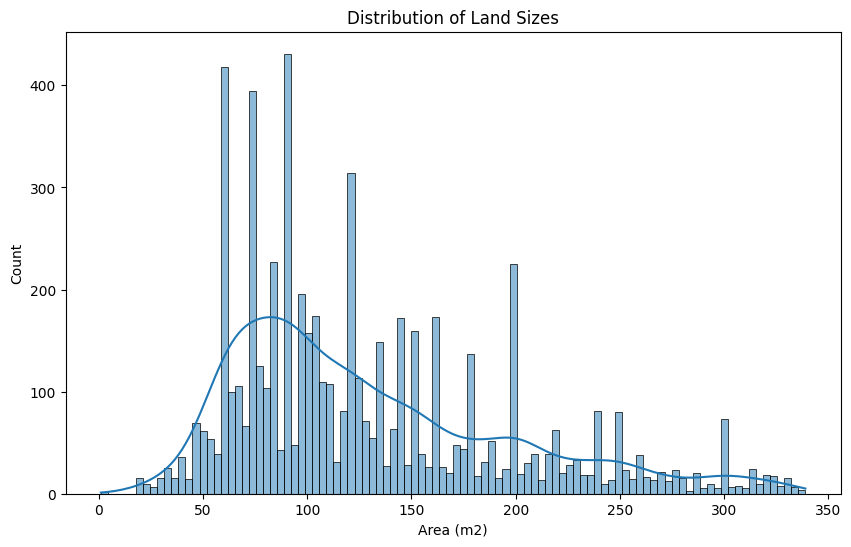

In [97]:
# ── Distribution of Prices ──
plt.figure(figsize=(10,6))
sns.histplot(df_sale['land_size_m2'], bins=100, kde=True)
plt.title("Distribution of Land Sizes")
plt.xlabel("Area (m2)")
plt.show()

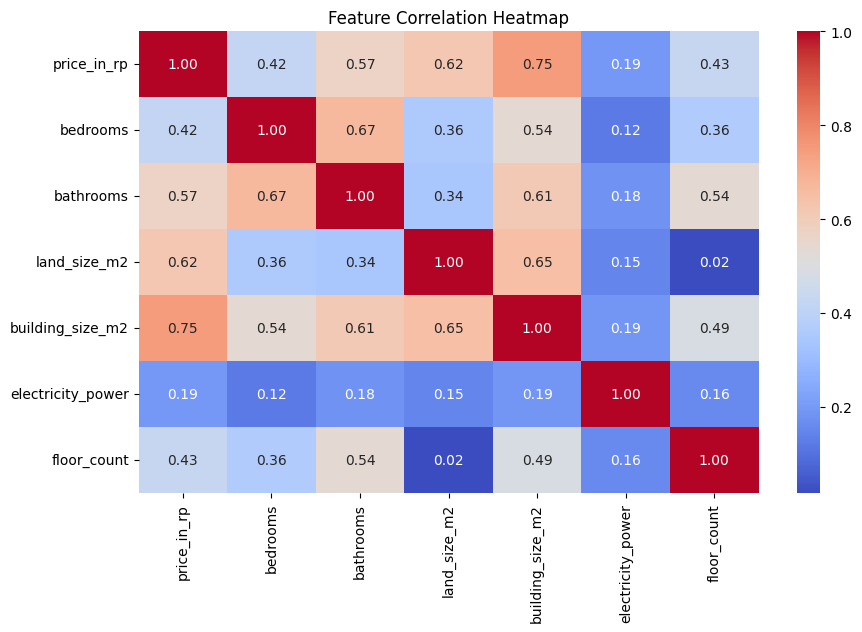

In [78]:
# ── Heatmap of Correlation ──
plt.figure(figsize=(10,6))
corr = df_sale.select_dtypes(include='number').corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

C:\Users\balse\AppData\Local\Temp\ipykernel_20760\1749380083.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=city_avg.values, y=city_avg.index, palette="Blues_d")


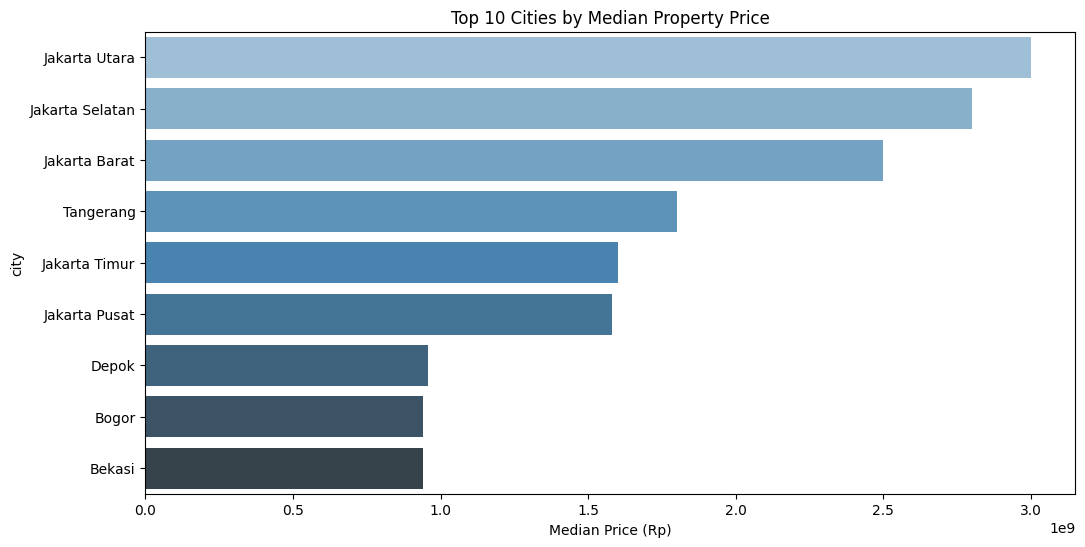

In [79]:
# ── Average Price by City ──
plt.figure(figsize=(12,6))
city_avg = df_sale.groupby('city')['price_in_rp'].median().sort_values(ascending=False).head(10)
sns.barplot(x=city_avg.values, y=city_avg.index, palette="Blues_d")
plt.title("Top 10 Cities by Median Property Price")
plt.xlabel("Median Price (Rp)")
plt.show()

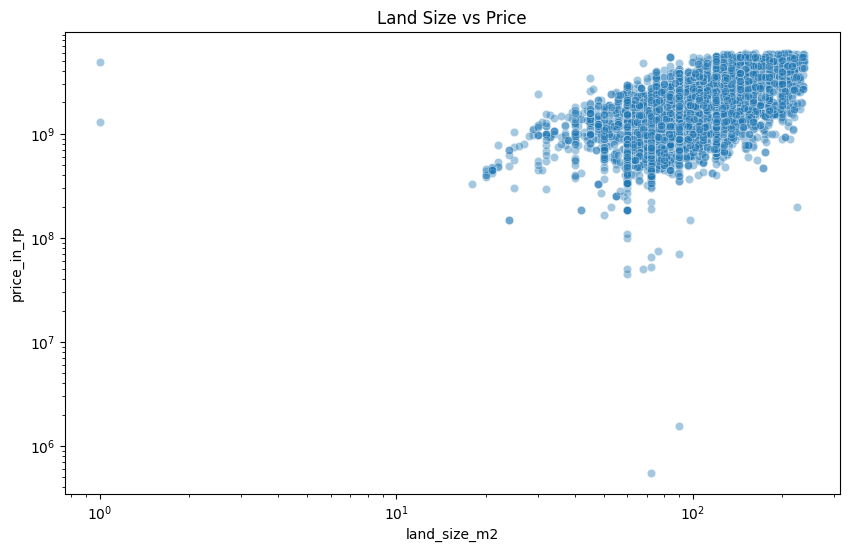

In [80]:
# ── Scatter: Land Size vs Price ──
plt.figure(figsize=(10,6))
sns.scatterplot(x='land_size_m2', y='price_in_rp', data=df_sale, alpha=0.4)
plt.title("Land Size vs Price")
plt.xscale('log')  # Optional if skewed
plt.yscale('log')
plt.show()

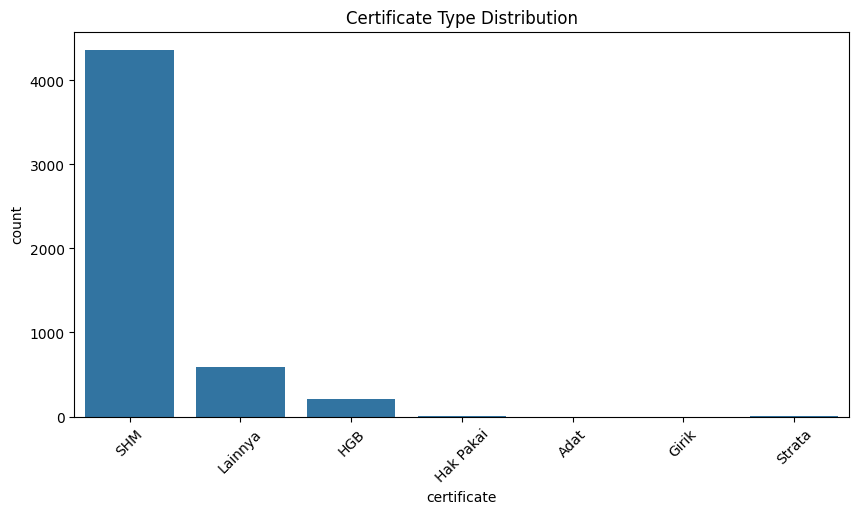

In [81]:
# ── Certificate Type Counts ──
plt.figure(figsize=(10,5))
sns.countplot(x='certificate', data=df_sale, order=df['certificate'].value_counts().index)
plt.title("Certificate Type Distribution")
plt.xticks(rotation=45)
plt.show()

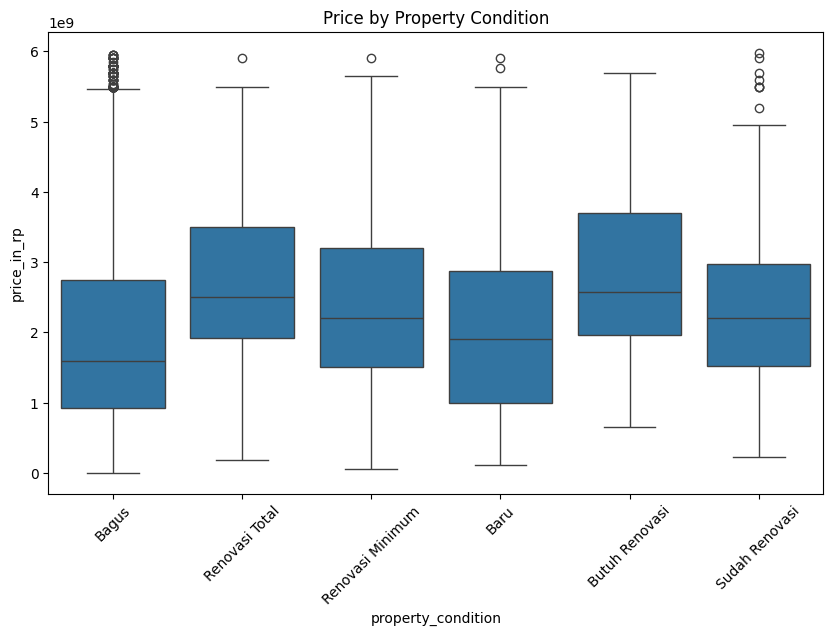

In [82]:
# ── Property Condition vs Price ──
plt.figure(figsize=(10,6))
sns.boxplot(x='property_condition', y='price_in_rp', data=df_sale)
plt.title("Price by Property Condition")
plt.xticks(rotation=45)
plt.show()

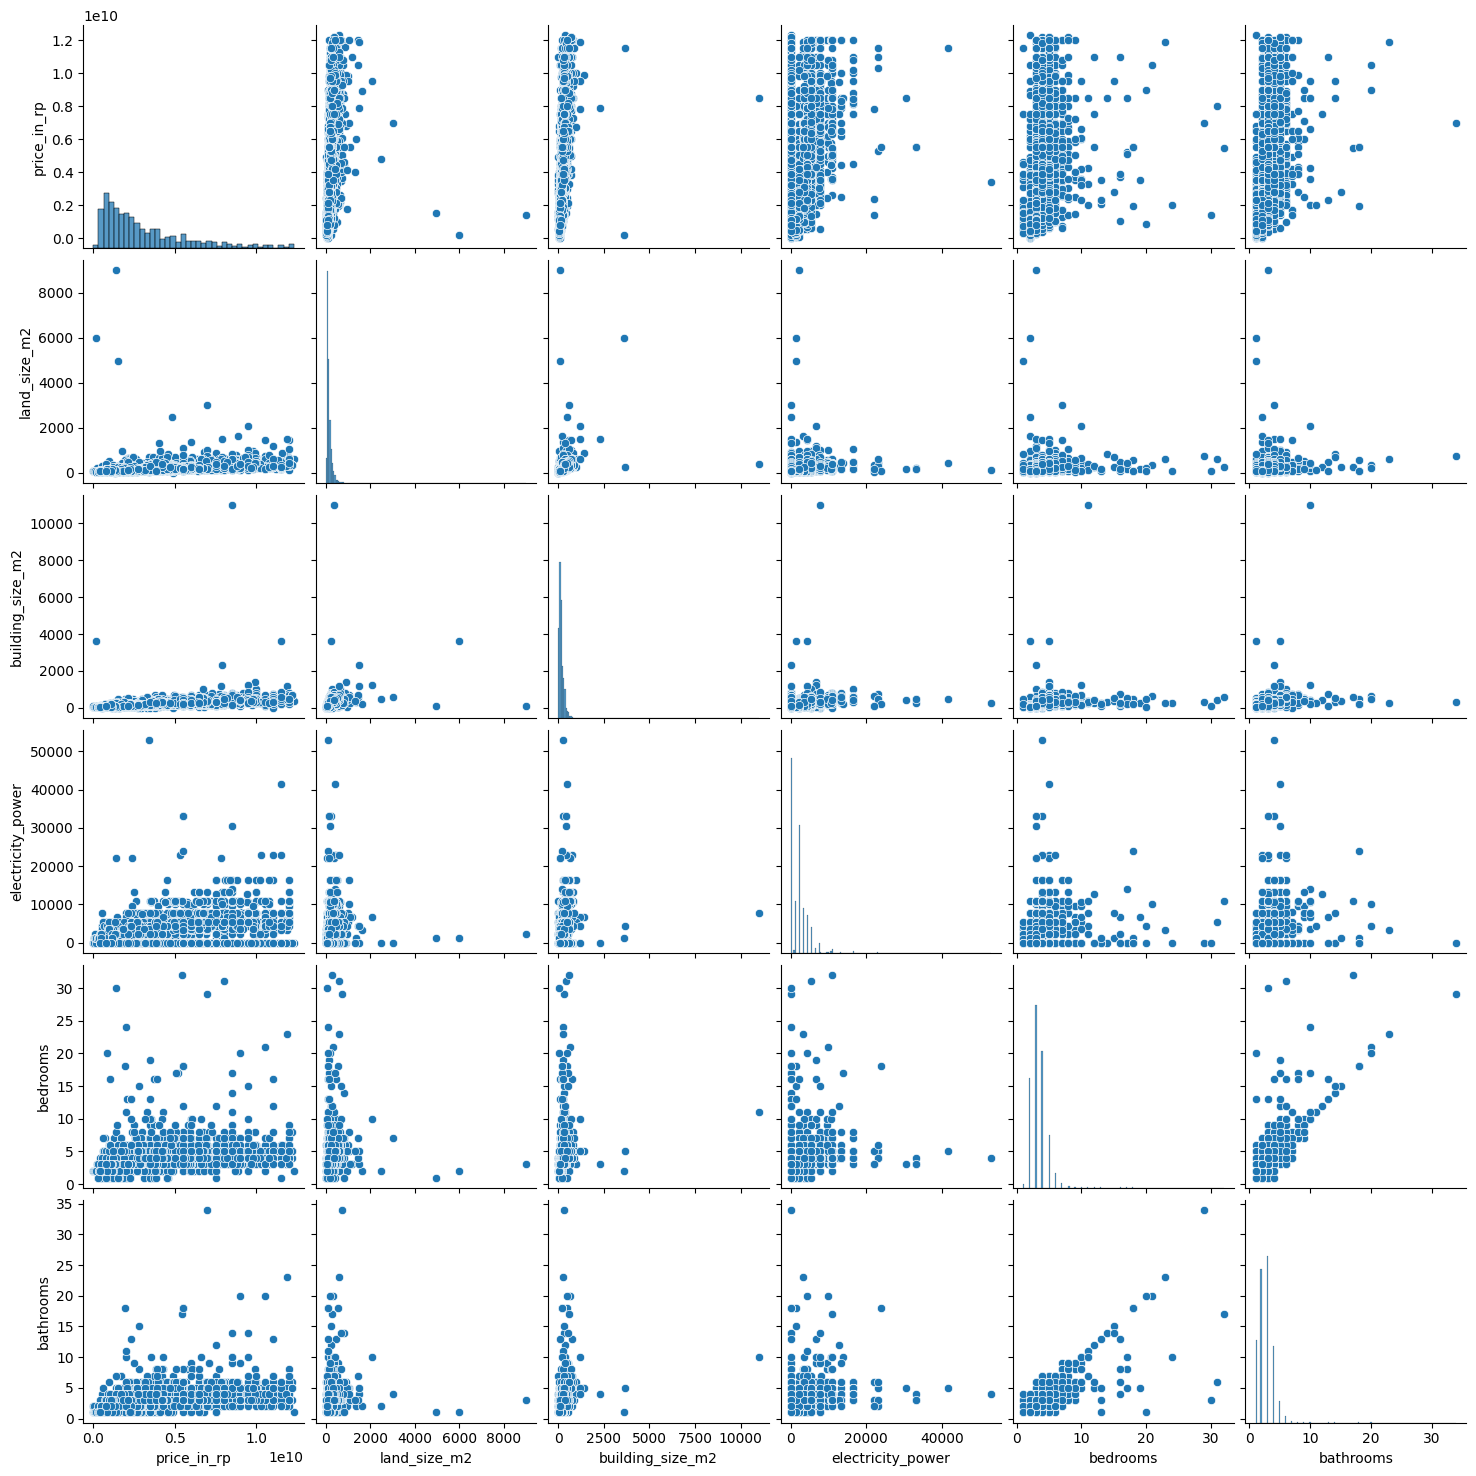

In [62]:
# ── Pairplot of Key Features ──
sns.pairplot(df_sale[['price_in_rp', 'land_size_m2', 'building_size_m2', 'electricity_power', 'bedrooms', 'bathrooms']])